### In this notebook we convert the raw data from Sentinel-2 into smaller images and store them on the disk

Steps:
1. open bands and extract transform/crs information
2. convert to numpy array and normalize bands input for deep learning\
   (https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af)
3. open and convert mask into numpy array
4. Stack bands to single array and patch them into smaller pieces with padding if needed
5. Patch mask
6. Save patched images and mask as tensor on disk  

In [2]:
# import packages
import os
from os import listdir
import re
import torch
from torch.utils.data import Dataset, DataLoader, sampler
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
from rasterio.features import rasterize
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import shapely

### 1. open bands and extract transform/crs information

In [3]:
# example folder which contains a single tile with bands 2-4, 8 and the TCI image
image_dir =  r'C:\Users\Fabian\Documents\Masterarbeit_Daten\API_test3\S2A_MSIL2A_20230301T100021_N0509_R122_T33UVP_20230301T142802'

In [4]:
# create dict to store filenames with bands as keys
band_file_map = {
    "B02": None, # blue
    "B03": None, # green
    "B04": None, # red
    "B08": None, # NIR
}

filename_regex = r"""^T(?P<tile>\d{2}[A-Z]{3})_(?P<date>\d{8}T\d{6})_(?P<band>B0\d{1})(?:_(?P<resolution>\d{2}m))?\..*$"""

# fill dict with paths and extract tile
for filename in os.listdir(image_dir):
    match = re.search(filename_regex, filename)
    if match:
        tile = match.group("tile")

    for band_name in band_file_map.keys():
        if filename.endswith(f"{band_name}_10m.jp2"):
            band_file_map[band_name] = os.path.join(image_dir, filename)
            break

# Verify that all required bands have been found
missing_bands = [band_name for band_name, file_path in band_file_map.items() if file_path is None]
if missing_bands:
    raise Exception(f"Missing band files: {missing_bands}")

# store open DatasetReaders in dict 
bands = {band_name: rasterio.open(file_path) for band_name, file_path in band_file_map.items()}

In [5]:
# get meta information's
img_crs = bands["B02"].crs
img_transform = bands["B02"].transform 

In [6]:
# read the bands form the DatasetReaders as numpy array, 1 is needed to get the right dimension (else unsqueeze) 
blue = bands["B02"].read(1)
green =  bands["B03"].read(1)
red = bands["B04"].read(1)
nir = bands["B08"].read(1)

### 2. convert to numpy array and normalize bands input for deep learning
   
https://medium.com/sentinel-hub/how-to-normalize-satellite-images-for-deep-learning-d5b668c885af

In [7]:
def robust_normalize(band, lower_bound=1, upper_bound=99):
    """ normalize data based on values inside the bounds """
    # get lower bound percentile
    perc_lower_bound = np.percentile(band, lower_bound)
    # set all lower bound outliers to perc_lower_bound value
    band[band < perc_lower_bound] = perc_lower_bound
    # get upper bound percentile
    perc_upper_bound = np.percentile(band, upper_bound)
    # set all upper bound outliers to perc_upper_bound value
    band[band > perc_upper_bound] = perc_upper_bound
    # normalize
    return (band-perc_lower_bound)/(perc_upper_bound - perc_lower_bound)

In [8]:
# consumes a lot of memory
blue_n = robust_normalize(blue)
green_n = robust_normalize(green)
red_n = robust_normalize(red)
nir_n = robust_normalize(nir)

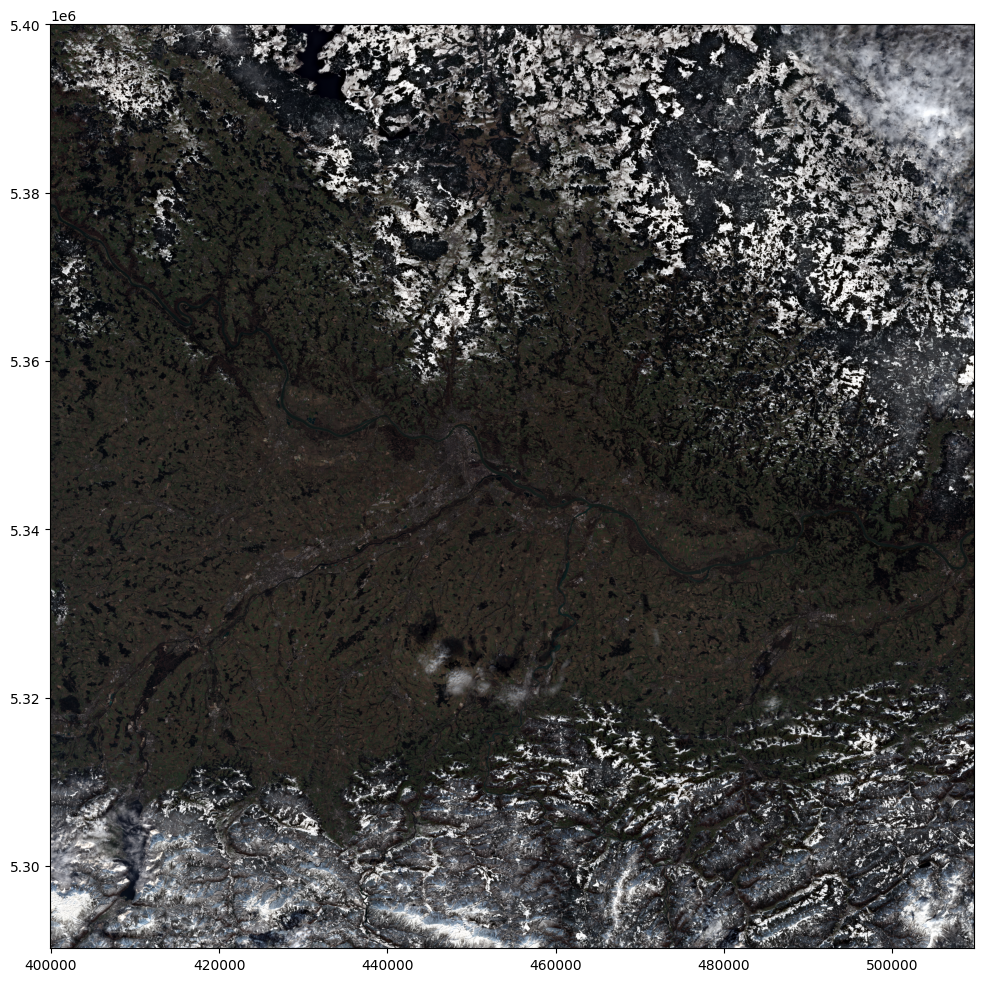

In [86]:
# plot RGB image
rgb_composite_corr = np.dstack((red_n, green_n, blue_n))
fig, ax = plt.subplots(1, figsize=(12, 12))
show(rgb_composite_corr.transpose((2,0,1)), transform=bands["B02"].transform, ax=ax);

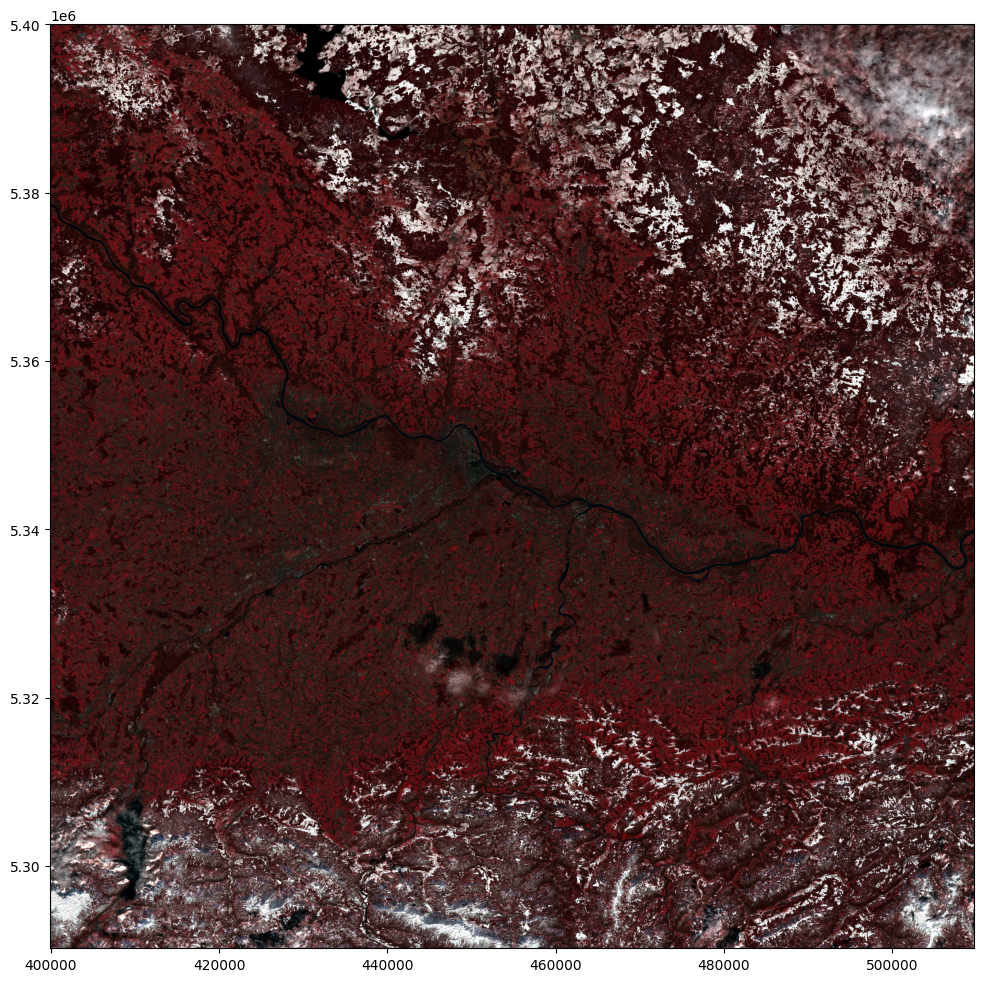

In [91]:
# plot false RGB image NIR R G
nir_composite_corr = np.dstack((nir_n, red_n, green_n))
fig, ax = plt.subplots(1, figsize=(12, 12))
show(nir_composite_corr.transpose((2,0,1)), transform=bands["B02"].transform, ax=ax);

### 3. open and convert mask into numpy array

In [9]:
# open file which contains the polygons for the masks (.shp or .geojson)
mask_path = r'C:\Users\Fabian\OneDrive - Universität Würzburg\Uni Würzburg\Master\Masterthesis\Code\Einarbeitung\polygons_bavaria_cleaned.geojson'
mask_gdf = gpd.read_file(mask_path)

In [10]:
# filter all masks to selected tile
masks  = mask_gdf[mask_gdf.Name==tile].geometry.reset_index(drop=True)

# convert crs
masks = masks.to_crs(bands['B02'].crs)

# affine based coordinate transformations
transform = bands['B02'].transform
# shape = pixels 
shape = bands['B02'].shape

# create a raster which matches the image shape
# invert=True so all masked pixels are set to True and all unmasked pixels are false (instead of the other way around)
# all_touched=True so all pixels within the masked are set to True (instead of the bounds) 
rasterized_mask = rasterio.features.geometry_mask(masks, out_shape=shape, transform=transform, invert=True, all_touched=True)

### 4. Stack bands to single array and patch them into smaller pieces with padding if needed

In [12]:
# stack all bands into one numpy array 
# consumes a lot of additional memory
stacked_bands = np.dstack((nir_n, red_n, green_n, blue_n))

# converts numpy array into tensor, transpose is needed because PyTorch expects channel first
stacked_bands_tensor =  torch.from_numpy(stacked_bands.transpose((2,0,1)))

In [ ]:
# show dimensions of Tensor, 4 because of NIR, R G B
channels, img_height, img_width = stacked_bands_tensor.shape
stacked_bands_tensor.shape

In [14]:
# size we could patch the images into#
# its best to use a number from the binary system (2^n)
# https://docs.nvidia.com/deeplearning/performance/dl-performance-gpu-background/index.html
kernel_size = 256
image_size = len(stacked_bands)

In [15]:
# calculate the padding size depending on the kernel size and the image size (/2 because the image is symmetric)
def padding_size(image_size :int, kernel_size :int) -> int:
    return int(((image_size//kernel_size + 1) * kernel_size - image_size) /2)

In [16]:
padding = padding_size(image_size, kernel_size)
padding

14

In [17]:
from torchvision.transforms import Pad
# execute padding on all bands in the array
# also a lot of memory
stacked_bands_tensor_pad = Pad(padding)(stacked_bands_tensor)
stacked_bands_tensor_pad.shape

torch.Size([4, 11008, 11008])

In [18]:
# patches the images into smaller pieces
tensor_patched = stacked_bands_tensor_pad.reshape(stacked_bands_tensor_pad.shape[0],
                    stacked_bands_tensor_pad.shape[1] // kernel_size,
                    kernel_size,
                    stacked_bands_tensor_pad.shape[1] // kernel_size,
                    kernel_size
                    )
# swap axis to get the right order                    
tensor_patched = tensor_patched.swapaxes(-3, -2)

In [23]:
# result
tensor_patched.shape

torch.Size([4, 43, 43, 256, 256])

In [283]:
# how to select a single image NIR R B
torch.Tensor.numpy(tensor_patched[:3, 0,0]).shape

(3, 256, 256)

<Axes: >

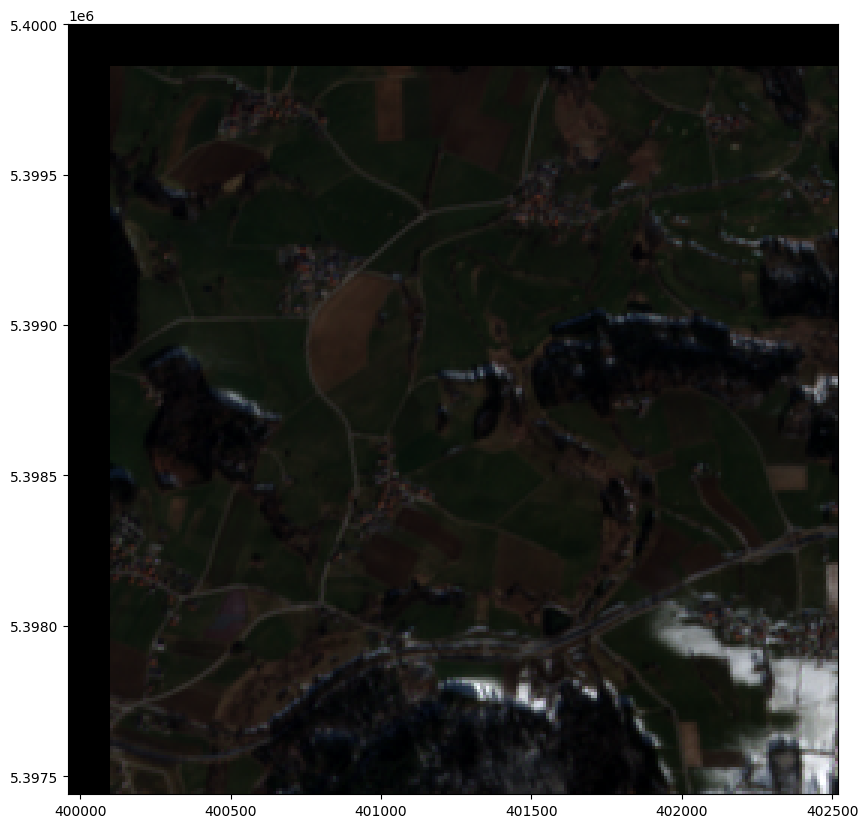

In [290]:
# tensor_patched[1:4, 0,0] for RGB
# tensor_patched[0:3, 0,0] for NIR R B
# black bars due to the padding
fig, ax = plt.subplots(1, figsize=(10, 10))
show(torch.Tensor.numpy(tensor_patched[1:4, 0,0]), transform=bands["B02"].transform, ax=ax)

### 5. Patch mask

#### Same procedure as for the image, but just one channel

In [26]:
rasterized_mask.shape

(10980, 10980)

In [20]:
mask_tensor = torch.from_numpy(rasterized_mask)

In [21]:
def convert_mask(mask):
    padding = padding_size(mask.shape[1], kernel_size)
    pad = Pad(padding, fill=False)(mask)
    patched = pad.reshape(
                    pad.shape[1] // kernel_size,
                    kernel_size,
                    pad.shape[1] // kernel_size,
                    kernel_size
                    )
    patched = patched.swapaxes(-3, -2)
    return patched

In [24]:
mask_patched = convert_mask(mask_tensor)
mask_patched.swapaxes(-3, -2).shape

torch.Size([43, 43, 256, 256])

<Axes: >

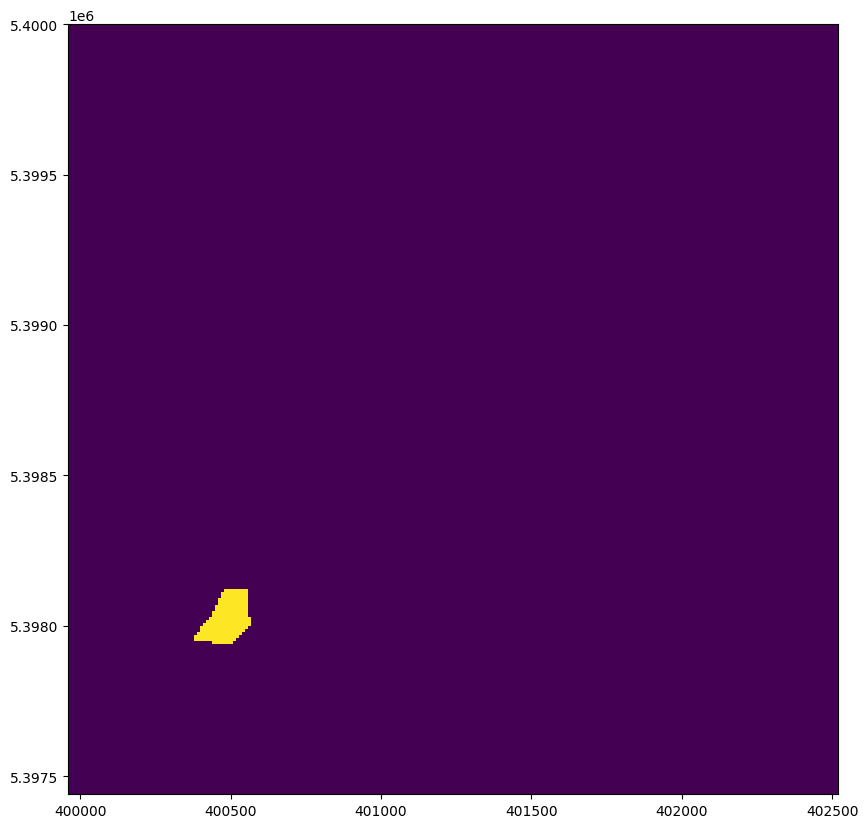

In [308]:
fig, ax = plt.subplots(1, figsize=(10, 10))
show(torch.Tensor.numpy(mask_patched[0, 0]), transform=bands["B02"].transform, ax=ax)

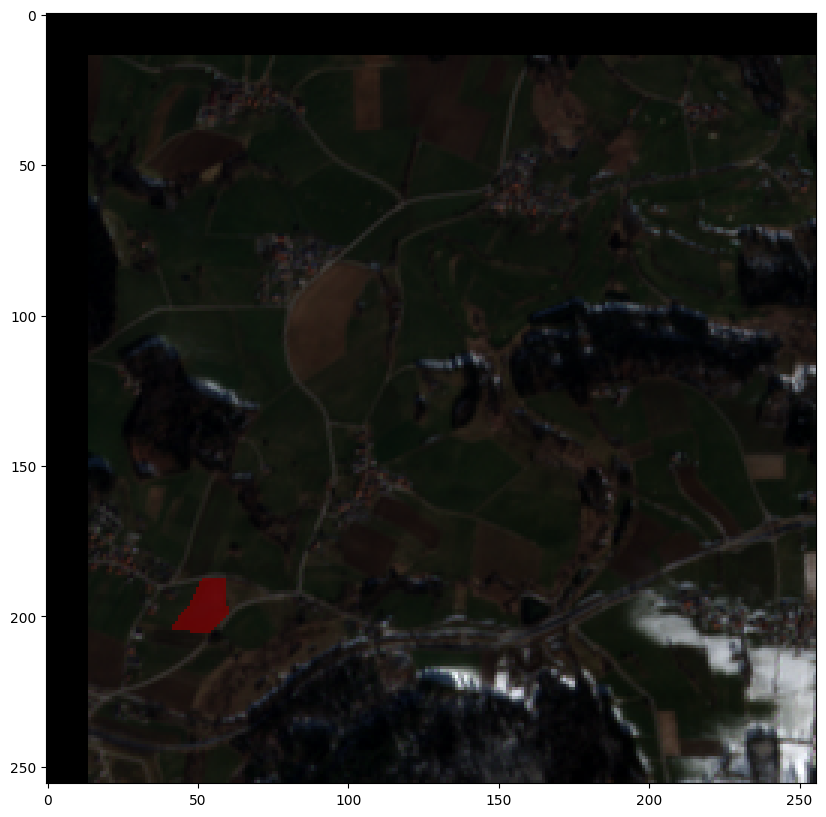

In [313]:
# check if they still match
plt.figure(figsize=(10, 10))
plt.imshow(torch.Tensor.numpy(tensor_patched[1:4, 0,0]).transpose((1,2,0)))
plt.imshow(torch.Tensor.numpy(mask_patched[0, 0]), 'jet', alpha=0.7*(torch.Tensor.numpy(mask_patched[0, 0])==True))

### 6. Save patched images and mask as tensor on disk

In [343]:
# clone is need to just save the slice of the tensor, else torch will save the whole tensor to disk
# .float() is used to convert the tensor to float32 which uses half of the space on the disk than float64 (.double())
torch.save(tensor_patched[:, 0,0].clone().float(), r'C:\Users\Fabian\Documents\Masterarbeit_Daten\images_test\test.pt')

In [ ]:
# iterate over 
# ToDo: add date
image_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\images_test'
mask_dir = r'C:\Users\Fabian\Documents\Masterarbeit_Daten\masks_test'

for i in range(tensor_patched.shape[1] - 1):
    for j in range(tensor_patched.shape[2] - 1):
        torch.save(tensor_patched[:, i,j].clone().float(), os.path.join(image_dir, '{tile}_date_{i}_{j}.pt'))

Check if the loaded image/mask work as expected

In [31]:
test_image_load = torch.load(os.path.join(image_dir, f'{tile}_date_{i}_{j}.pt'))

In [32]:
test_mask_load = torch.load(os.path.join(mask_dir, f'{tile}_date_{i}_{j}.pt'))

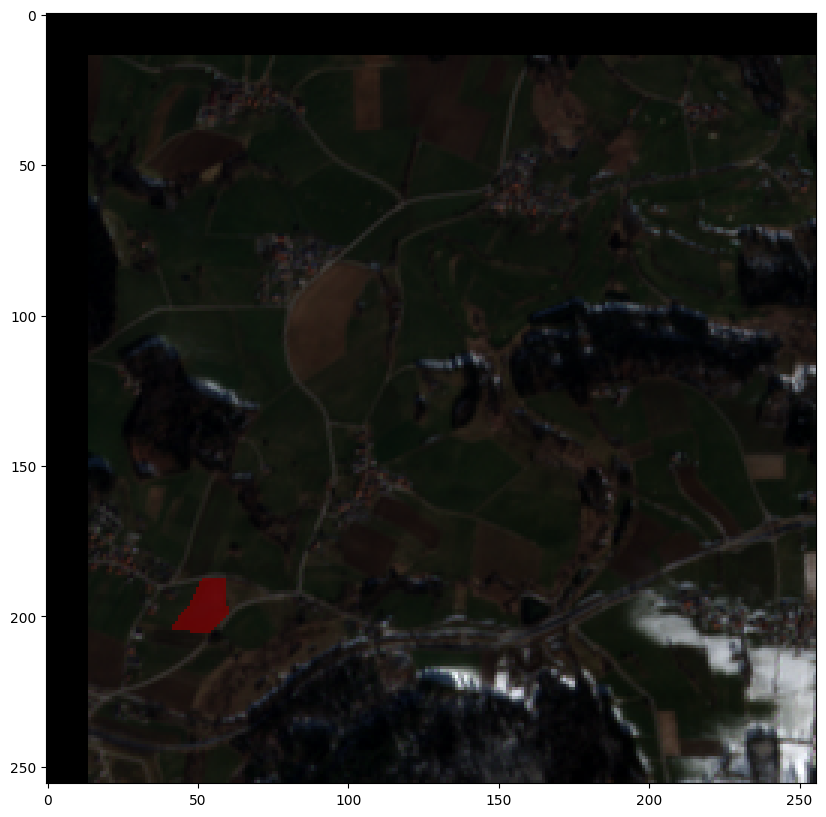

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(torch.Tensor.numpy(test_image_load[1:4,:,:]).transpose((1,2,0)))
plt.imshow(torch.Tensor.numpy(test_mask_load), 'jet', alpha=0.7*(torch.Tensor.numpy(test_mask_load)==True))